# Predicting hotel booking cancellations in Python


This project aims to develop predictive model thaht can predict whether a customer will cancel a hotel booking or not. By identify pattern from historical data on hotel reservations , customer information, and other features. The goal is to assist hotel managemnt to optimizing reservation management, increasing room utlilization, and reducing losses due to cancellations.

In [6]:
# Data imports
import pandas as pd
import numpy as np

# Visualization imports
import plotly.express as px

# ML Imports and configuration
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import set_config
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
set_config(display="diagram")

## 1. Import the data

The first step in any machine learning workflow is to get the data and explore it.

In [8]:
hotel_bookings = pd.read_csv('hotel_bookings.csv')
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


As a quick exploration, let us look at the number of bookings by month.

In [9]:
bookings_by_month = hotel_bookings.groupby('arrival_date_month', as_index=False)[['hotel']].count().rename(columns={"hotel": "nb_bookings"})
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] 
fig = px.bar(
    bookings_by_month, 
    x='arrival_date_month', 
    y='nb_bookings', 
    title=f'Hotel Bookings by Month', 
    category_orders={"arrival_date_month": months}
)
fig.show(config={"displayModeBar": False})

Our objective is to build a classification model - or classifier - that predicts whether or not a user cancelled a hotel booking.

## 1. Split the data into training and test sets.

Let us start by defining a split to divide the data into training and test sets. The basic idea is to train the model on a portion of the data and test its performance on the other portion that has not been seen by the model. This is done in order to prevent __overfitting__.

In [10]:
# List all numberical features
features_num = [
    "lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies", "is_repeated_guest" ,
    "previous_cancellations", "previous_bookings_not_canceled", "agent", "company", 
    "required_car_parking_spaces", "total_of_special_requests", "adr"
]

# List all categorical features
features_cat = [
    "hotel", "arrival_date_month", "meal", "market_segment", "distribution_channel", 
    "reserved_room_type", "deposit_type", "customer_type"
]

features = features_num + features_cat

X = hotel_bookings[features]
y = hotel_bookings["is_canceled"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 420)

## 2. Preprocess the data

The next step is to set up a pipeline to preprocess the features. We will impute all missing values with a constant, and one-hot encode all categorical features.

In [11]:
transformer_num = SimpleImputer(strategy="constant")

transformer_cat = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", transformer_num, features_num),
    ("cat", transformer_cat, features_cat)
])

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['lead_time', 'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled', 'agent',
                                  'company', 'required_car_parking_spaces',
                                  'total_of_special_requests', 'adr']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['hotel', 'arrival_date_month', 'meal',
                                  'market_segment', 'distribution_channel',
                                  'reserved_room_type', 'deposit_type',
                                  'customer_type'])])

## 4. Fit the models and evaluate performance

Next, we extend the pipeline to fit a Decision Tree model on the training data.

In [12]:
# Compose data preprocessing and model into a single pipeline
steps = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=1234))
])
steps.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'agent', 'company',
                                                   'r...
                                                   'total_of_special_requests',
                                                   'adr']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('model', DecisionTreeClassifier(random_state=1234))])

To see how well our model performed, we'll calculate and visualize a confusion matrix, and calculate the accuracy of the model

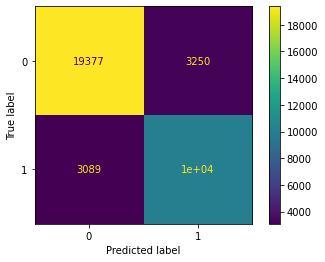

In [ ]:
plot_confusion_matrix(steps, X_test, y_test)

In [13]:
y_pred = steps.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)
conf = confusion_matrix(y_test, y_pred)
accuracy = float((conf[0][0] + conf[1][1]))/float(np.sum(conf))
print(accuracy)

0.823017003099087
0.823017003099087


## The end!

With this trained pipeline, we can now predict whether or not a new, previously unsoon booking will be cancelled with an accuracy of roughly 80%. This can be useful in planning room availability or identifying which guests are at risk of cancelling their booking to take corrective action.

## Reference: Data Dictionary

|variable                        |class       |description                                                                                      |
|:-------------------------------|:-----------|:------------------------------------------------------------------------------------------------|
|adr                             |numeric     |Average daily rate                                                                               |
|adults                          |integer     |Number of adults                                                                                 |
|agent                           |categorical |The id of the travel agency                                                                      |
|arrival_date_day_of_month       |integer     |Day of the month of the arrival date                                                             |
|arrival_date_month              |categorical |Month of arrival date with 12 categories: “January” to “December”                                |
|arrival_date_week_number        |integer     |Week number of the arrival date                                                                  |
|arrival_date_year               |integer     |Year of arrival date                                                                             |
|assigned_room_type              |categorical |The code for type of room assigned                                                               |
|babies                          |integer     |Number of babies                                                                                 |
|booking_changes                 |integer     |The number of changes made to the booking                                                        |
|children                        |integer     |Number of children                                                                               |
|company                         |categorical |The id of the company making the booking                                                         |
|country                         |categorical |The country of originin ISO 3155-3:2013 format                                                   |
|customer_type                   |categorical |The type of booking: Contract / Group / Transient / Transient-Party                              |
|days_in_waiting_list            |integer     |The number of days the booking was in the waiting list                                           |
|deposit_type                    |categorical |The type of deposit: No Deposit / Non Refund / Refundable                                        |
|distribution_channel            |categorical |The booking distribution channel: TA / TO etc.                                                   |
|is_cancelled                    |categorical |A boolean indicating if the booking was cancelled (1) or not (0)                                 |
|is_repeated_guest               |categorical |A boolean indicating if it was a repeated guest (1) or not (0)                                   |
|lead_time                       |integer     |The number of days between the booking date and arrival date                                     |
|market_segment                  |categorical |A designation for the market segment: TA. TO                                                     |
|meal                            |categorical |The type of meal booked: Bed & Breakfast (BB), Half Board (HB), and Full Board (FB)              |
|previous_bookings_not_cancelled |integer     |The number of previous bookings not cancelled by the customer prior to the current booking       |
|previous_cancellations          |integer     |The number of previous bookings that were cancelled by the customer prior to the current booking |
|required_car_parking_spaces     |integer     |The number of car parking spaces required by the customer                                        |
|reservation_status              |categorical |The last status of the reservation: Canceled / Check-Out / No-Show                               |
|reservation_status_date         |date        |The date at which the last status was set.                                                       |
|reserved_room_type              |categorical |The code of room type reserved.                                                                  |
|stays_in_weekend_nights         |integer     |The number of weekend nights stayed or booked to stay                                            |
|stays_in_week_nights            |integer     |The number of week nights stayed or booked to stay                                               |
|total_of_special_requests       |integer     |The number of special requests made by the customer                                              |